An **SVM** classifier (RBF kernel) with the default features and a new Family feature: number of parents + number of siblings. 
Cross-validation over the parameters C and gamma.
**Performance score: 0.77033.**

Alternatively, a **Random Forest classifier** with the same set of features. 
Cross-validation over the number of trees and impurity metrics.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series,DataFrame
import collections as cln

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import preprocessing
pd.options.mode.chained_assignment = None
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

genderclassmodel.csv
gendermodel.csv
gendermodel.py
myfirstforest.py
test.csv
train.csv



In [2]:
survived_color = '#6699ff'
died_color = '#ff6666'

na_string = 'NA'
na_number = 0

width = 0.35
embarked_map = {'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown', na_string: 'N/A'}
pclass_map = {1: 'First class', 2: 'Second class', 3: 'Third class'}

# helper method
def ensure_na(d):
    if not na_string in d:
        d[na_string] = 0
    return d

In [3]:
# Read data and fill NA values with -1

titanic_df = pd.read_csv("../input/train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("../input/test.csv", dtype={"Age": np.float64}, )

# indexes of survived and died 
idx_survived = titanic_df['Survived'] == 1
idx_died = np.logical_not(idx_survived)

titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['Name','Ticket'], axis=1)

titanic_df["Embarked"] = titanic_df["Embarked"].fillna(na_string)
titanic_df["Fare"] = titanic_df["Fare"].fillna(na_number)
titanic_df["Age"] = titanic_df["Age"].fillna(na_number)
titanic_df["Cabin"] = titanic_df["Cabin"].fillna(na_string)

test_df["Embarked"] = test_df["Embarked"].fillna(na_string)
test_df["Fare"] = test_df["Fare"].fillna(na_number)
test_df["Age"] = test_df["Age"].fillna(na_number)
test_df["Cabin"] = test_df["Cabin"].fillna(na_string)

# features so far
titanic_df[:10]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NA,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NA,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NA,S
5,0,3,male,0.0,0,0,8.4583,NA,Q
6,0,1,male,54.0,0,0,51.8625,E46,S
7,0,3,male,2.0,3,1,21.0750,NA,S
8,1,3,female,27.0,0,2,11.1333,NA,S
9,1,2,female,14.0,1,0,30.0708,NA,C


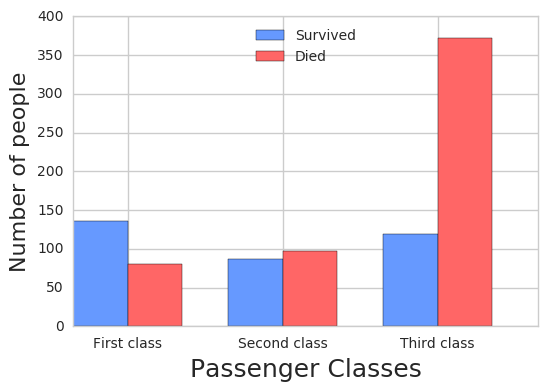

In [4]:
# Pclass

pclass_survived = titanic_df[idx_survived].Pclass
pclass_died = titanic_df[idx_died].Pclass
pclass_survived_counts = ensure_na(titanic_df[idx_survived].Pclass.value_counts())
pclass_died_counts = ensure_na(titanic_df[idx_died].Pclass.value_counts())

# we get no NA values for Pclass feature
# so we remove NA from plots and sort the rest of values by index
pclass_survived_sorted = pclass_survived_counts[0:3].sort_index()
pclass_died_sorted = pclass_died_counts[0:3].sort_index()

N = len(pclass_survived_sorted)
ind = np.arange(N)

plot1 = plt.bar(ind, pclass_survived_sorted, width, color=survived_color, label='Survived')
plot2 = plt.bar(ind + width, pclass_died_sorted, width, color=died_color, label='Died')

plt.xlabel('Passenger Classes', fontsize=18)
plt.ylabel('Number of people', fontsize=16)
plt.legend(loc='upper center')
plt.xticks(ind + width, (pclass_map[l] for l in pclass_survived_sorted.keys()))
plt.show()

# make dummies from Pclass feature

pclass_dummies_titanic  = pd.get_dummies(titanic_df['Pclass'])
pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']

titanic_df = titanic_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

titanic_df.drop(['Pclass'], axis=1, inplace=True)
test_df.drop(['Pclass'], axis=1, inplace=True)

In [5]:
# Sex

sex_dummies_titanic  = pd.get_dummies(titanic_df['Sex'])
sex_dummies_test     = pd.get_dummies(test_df['Sex'])

titanic_df = titanic_df.join(sex_dummies_titanic)
test_df    = test_df.join(sex_dummies_test)

titanic_df.drop(['Sex'], axis=1, inplace=True)
test_df.drop(['Sex'], axis=1, inplace=True)

# show features so far
titanic_df[:10]

,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Class_1,Class_2,Class_3,female,male
0,0,22.0,1,0,7.2500,NA,S,0.0,0.0,1.0,0.0,1.0
1,1,38.0,1,0,71.2833,C85,C,1.0,0.0,0.0,1.0,0.0
2,1,26.0,0,0,7.9250,NA,S,0.0,0.0,1.0,1.0,0.0
3,1,35.0,1,0,53.1000,C123,S,1.0,0.0,0.0,1.0,0.0
4,0,35.0,0,0,8.0500,NA,S,0.0,0.0,1.0,0.0,1.0
5,0,0.0,0,0,8.4583,NA,Q,0.0,0.0,1.0,0.0,1.0
6,0,54.0,0,0,51.8625,E46,S,1.0,0.0,0.0,0.0,1.0
7,0,2.0,3,1,21.0750,NA,S,0.0,0.0,1.0,0.0,1.0
8,1,27.0,0,2,11.1333,NA,S,0.0,0.0,1.0,1.0,0.0
9,1,14.0,1,0,30.0708,NA,C,0.0,1.0,0.0,1.0,0.0


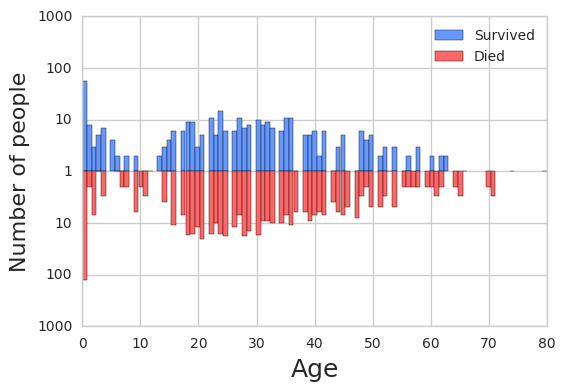

In [6]:
# Age
age_survived = titanic_df[idx_survived].Age
age_died = titanic_df[idx_died].Age

minAge, maxAge = min(titanic_df.Age), max(titanic_df.Age)
bins = np.linspace(minAge, maxAge, 100)

age_survived_counts, _ = np.histogram(age_survived, bins)
age_died_counts, _ = np.histogram(age_died, bins)

plt.bar(bins[:-1], np.log10(age_survived_counts), color=survived_color, label='Survived')
plt.bar(bins[:-1], -np.log10(age_died_counts), color=died_color, label='Died')
plt.yticks(range(-3,4), (10**abs(k) for k in range(-3,4)))
plt.legend(loc='upper right')
plt.xlabel('Age', fontsize=18)
plt.ylabel('Number of people', fontsize=16)
plt.show()

# Normalization
maxAge = max(titanic_df['Age'])
titanic_df['Age'] /= maxAge
test_df['Age'] /= maxAge

# New feature for Age
titanic_df['AgeNA'] = titanic_df['Age']
titanic_df['AgeNA'].loc[titanic_df['Age'] > 0] = 0
titanic_df['AgeNA'].loc[titanic_df['Age'] <= 0] = 1

test_df['AgeNA'] = test_df['Age']
test_df['AgeNA'].loc[test_df['Age'] > 0] = 0
test_df['AgeNA'].loc[test_df['Age'] <= 0] = 1

In [7]:
# Family members = Parch + SibSp

titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]

# Normalization
maxFamily = max(titanic_df['Family'])
titanic_df['Family'] /= maxFamily
test_df['Family'] /= maxFamily

# print features so far
titanic_df[:10]

,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Class_1,Class_2,Class_3,female,male,AgeNA,Family
0,0,0.2750,1,0,7.2500,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.1
1,1,0.4750,1,0,71.2833,C85,C,1.0,0.0,0.0,1.0,0.0,0.0,0.1
2,1,0.3250,0,0,7.9250,NA,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1,0.4375,1,0,53.1000,C123,S,1.0,0.0,0.0,1.0,0.0,0.0,0.1
4,0,0.4375,0,0,8.0500,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0,0.0000,0,0,8.4583,NA,Q,0.0,0.0,1.0,0.0,1.0,1.0,0.0
6,0,0.6750,0,0,51.8625,E46,S,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0,0.0250,3,1,21.0750,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.4
8,1,0.3375,0,2,11.1333,NA,S,0.0,0.0,1.0,1.0,0.0,0.0,0.2
9,1,0.1750,1,0,30.0708,NA,C,0.0,1.0,0.0,1.0,0.0,0.0,0.1


   SibSp  SibSp
0  210.0    398
1  112.0     97
2   13.0     15
3    4.0     12
4    3.0     15
5    0.0      5
8    0.0      7


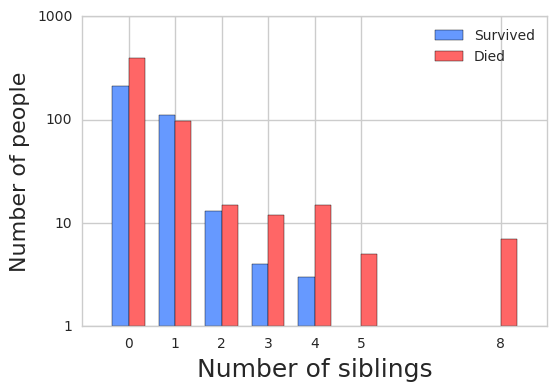

In [8]:
# SibSp
sibsp_survived = titanic_df[idx_survived].SibSp
sibsp_died = titanic_df[idx_died].SibSp

sibsp_survived_counts = titanic_df[idx_survived].SibSp.value_counts().sort_index()
sibsp_died_counts = titanic_df[idx_died].SibSp.value_counts().sort_index()

df = pd.concat([sibsp_survived_counts, sibsp_died_counts], axis=1).fillna(0)
print(df)

plot1 = plt.bar(df.index.values - width, np.log10(df.ix[:,0]), width, color=survived_color, label='Survived')
plot2 = plt.bar(df.index.values, np.log10(df.ix[:,1]), width, color=died_color, label='Died')

plt.xlabel('Number of siblings', fontsize=18)
plt.ylabel('Number of people', fontsize=16)
plt.yticks(range(0,4), (10**abs(k) for k in range(0,4)))
plt.xticks(df.index.values)
plt.legend(loc='upper right')
plt.show()

# Normalization
maxSibSp = max(titanic_df['SibSp'])
titanic_df['SibSp'] /= maxSibSp
test_df['SibSp'] /= maxSibSp

   Parch  Parch
0  233.0    445
1   65.0     53
2   40.0     40
3    3.0      2
4    0.0      4
5    1.0      4
6    0.0      1


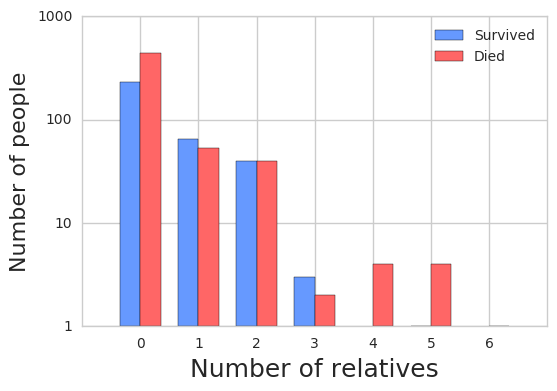

,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Class_1,Class_2,Class_3,female,male,AgeNA,Family
0,0,0.2750,0.125,0.000000,7.2500,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.1
1,1,0.4750,0.125,0.000000,71.2833,C85,C,1.0,0.0,0.0,1.0,0.0,0.0,0.1
2,1,0.3250,0.000,0.000000,7.9250,NA,S,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1,0.4375,0.125,0.000000,53.1000,C123,S,1.0,0.0,0.0,1.0,0.0,0.0,0.1
4,0,0.4375,0.000,0.000000,8.0500,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0,0.0000,0.000,0.000000,8.4583,NA,Q,0.0,0.0,1.0,0.0,1.0,1.0,0.0
6,0,0.6750,0.000,0.000000,51.8625,E46,S,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0,0.0250,0.375,0.166667,21.0750,NA,S,0.0,0.0,1.0,0.0,1.0,0.0,0.4
8,1,0.3375,0.000,0.333333,11.1333,NA,S,0.0,0.0,1.0,1.0,0.0,0.0,0.2
9,1,0.1750,0.125,0.000000,30.0708,NA,C,0.0,1.0,0.0,1.0,0.0,0.0,0.1


In [9]:
# Parch

parch_survived = titanic_df[idx_survived].Parch
parch_died = titanic_df[idx_died].Parch

parch_survived_counts = titanic_df[idx_survived].Parch.value_counts().sort_index()
parch_died_counts = titanic_df[idx_died].Parch.value_counts().sort_index()

df = pd.concat([parch_survived_counts, parch_died_counts], axis=1).fillna(0)
print(df)

plot1 = plt.bar(df.index.values - width, np.log10(df.ix[:,0]), width, color=survived_color, label='Survived')
plot2 = plt.bar(df.index.values, np.log10(df.ix[:,1]), width, color=died_color, label='Died')

plt.xlabel('Number of relatives', fontsize=18)
plt.ylabel('Number of people', fontsize=16)
plt.yticks(range(0,4), (10**abs(k) for k in range(0,4)))
plt.xticks(df.index.values)
plt.legend(loc='upper right')
plt.show()

# Normalization
maxParch = max(titanic_df['Parch'])
titanic_df['Parch'] /= maxParch
test_df['Parch'] /= maxParch

# features so far
titanic_df[:10]

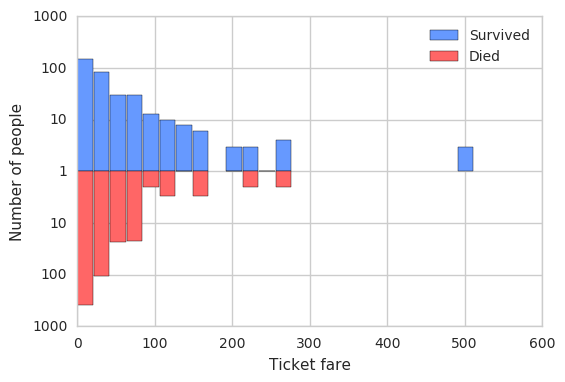

In [10]:
# Fare
fare_survived = titanic_df[idx_survived].Fare
fare_died = titanic_df[idx_died].Fare

minFare, maxFare = min(titanic_df.Fare), max(titanic_df.Fare)
bins = np.linspace(minFare, maxFare, 25)

fare_survived_counts, _ = np.histogram(fare_survived, bins)
fare_died_counts, _ = np.histogram(fare_died, bins)

plt.figure()
plt.bar(bins[:-1], np.log10(fare_survived_counts), width=20, color=survived_color, label='Survived')
plt.bar(bins[:-1], -np.log10(fare_died_counts), width=20, color=died_color, label='Died')
plt.ylabel('Number of people')
plt.xlabel('Ticket fare')
plt.yticks(range(-3,4), (10**abs(k) for k in range(-3,4)))
plt.legend()
plt.show()

# Normalization
maxFare = max(titanic_df['Fare'])
titanic_df['Fare'] /= maxFare
test_df['Fare'] /= maxFare

# New feature for Fare
titanic_df['FareNA'] = titanic_df['Fare']
titanic_df['FareNA'].loc[titanic_df['Fare'] > 0] = 0
titanic_df['FareNA'].loc[titanic_df['Fare'] <= 0] = 1

test_df['FareNA'] = test_df['Fare']
test_df['FareNA'].loc[test_df['Fare'] > 0] = 0
test_df['FareNA'].loc[test_df['Fare'] <= 0] = 1

In [11]:
# Cabin

def removeDigits(col):
    return col.replace('[0-9]+', '', regex=True)

titanic_df['Cabin'] = removeDigits(titanic_df['Cabin'])
test_df['Cabin'] = removeDigits(test_df['Cabin'])

cabin_train = pd.get_dummies(titanic_df['Cabin'])
cabin_test = pd.get_dummies(test_df['Cabin'])

cabin_train.columns = ['cabin_' + name for name in cabin_train.columns]
cabin_test.columns = ['cabin_' + name for name in cabin_test.columns]

train_cols = set(cabin_train.columns)
test_cols = set(cabin_test.columns)

for col in (train_cols - test_cols) | (test_cols - train_cols):
    if col in train_cols:
        cabin_train.drop([col], axis=1, inplace=True)
    if col in test_cols:
        cabin_test.drop([col], axis=1, inplace=True)
    print('Column dropped: %s' % col)
    
titanic_df = titanic_df.join(cabin_train)
test_df    = test_df.join(cabin_test)

titanic_df.drop(['Cabin'], axis=1, inplace=True)
test_df.drop(['Cabin'], axis=1, inplace=True)

# features so far
titanic_df[:10]

Column dropped: cabin_T
Column dropped: cabin_E E


,Survived,Age,SibSp,Parch,Fare,Embarked,Class_1,Class_2,Class_3,female,...,cabin_C C,cabin_C C C,cabin_D,cabin_D D,cabin_E,cabin_F,cabin_F E,cabin_F G,cabin_G,cabin_NA
0,0,0.2750,0.125,0.000000,0.014151,S,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0.4750,0.125,0.000000,0.139136,C,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.3250,0.000,0.000000,0.015469,S,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0.4375,0.125,0.000000,0.103644,S,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.4375,0.000,0.000000,0.015713,S,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,0.0000,0.000,0.000000,0.016510,Q,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,0.6750,0.000,0.000000,0.101229,S,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0250,0.375,0.166667,0.041136,S,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1,0.3375,0.000,0.333333,0.021731,S,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1,0.1750,0.125,0.000000,0.058694,C,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


S     217
C      93
Q      30
NA      2
Name: Embarked, dtype: int64
S     427
C      75
Q      47
NA      0
Name: Embarked, dtype: int64


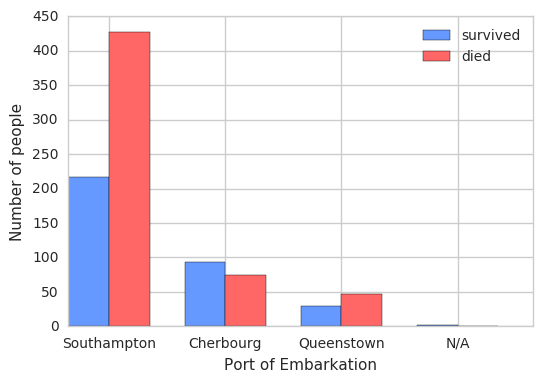

In [12]:
# Embarked

survived_embarked_counts = ensure_na(titanic_df[idx_survived].Embarked.value_counts())
died_embarked_counts = ensure_na(titanic_df[idx_died].Embarked.value_counts())
print(survived_embarked_counts)
print(died_embarked_counts)
assert(len(survived_embarked_counts) == len(died_embarked_counts))

N = len(survived_embarked_counts)
ind = np.arange(N) 
plot1 = plt.bar(ind, survived_embarked_counts, width, color=survived_color)
plot2 = plt.bar(ind + width, died_embarked_counts, width, color=died_color)

plt.ylabel('Number of people')
plt.xlabel('Port of Embarkation')
plt.xticks(ind + width, (embarked_map[k] for k in survived_embarked_counts.keys()))
plt.legend((plot1[0], plot2[0]), ('survived', 'died'))
plt.show()

# Embarked train/test get dummies
embark_dummies_titanic  = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_test  = pd.get_dummies(test_df['Embarked'])

embark_dummies_titanic.columns = ['port_' + name for name in embark_dummies_titanic.columns]
embark_dummies_test.columns = ['port_' + name for name in embark_dummies_test.columns]

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df    = test_df.join(embark_dummies_test)

titanic_df.drop(['Embarked'], axis=1, inplace=True)
test_df.drop(['Embarked'], axis=1, inplace=True)

# drop port_NA because it exists in train only
titanic_df.drop(['port_NA'], axis=1, inplace=True)

In [13]:
# train before training
titanic_df[:10]

,Survived,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,...,cabin_D D,cabin_E,cabin_F,cabin_F E,cabin_F G,cabin_G,cabin_NA,port_C,port_Q,port_S
0,0,0.2750,0.125,0.000000,0.014151,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0.4750,0.125,0.000000,0.139136,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,0.3250,0.000,0.000000,0.015469,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0.4375,0.125,0.000000,0.103644,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0.4375,0.000,0.000000,0.015713,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0,0.0000,0.000,0.000000,0.016510,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,0,0.6750,0.000,0.000000,0.101229,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0,0.0250,0.375,0.166667,0.041136,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,1,0.3375,0.000,0.333333,0.021731,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,1,0.1750,0.125,0.000000,0.058694,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [14]:
# test before training
test_df[:10]

,PassengerId,Age,SibSp,Parch,Fare,Class_1,Class_2,Class_3,female,male,...,cabin_D D,cabin_E,cabin_F,cabin_F E,cabin_F G,cabin_G,cabin_NA,port_C,port_Q,port_S
0,892,0.43125,0.000,0.000000,0.015282,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,893,0.58750,0.125,0.000000,0.013663,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,894,0.77500,0.000,0.000000,0.018909,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,895,0.33750,0.000,0.000000,0.016908,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,896,0.27500,0.125,0.166667,0.023984,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,897,0.17500,0.000,0.000000,0.018006,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6,898,0.37500,0.000,0.000000,0.014891,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,899,0.32500,0.125,0.166667,0.056604,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,900,0.22500,0.000,0.000000,0.014110,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
9,901,0.26250,0.250,0.000000,0.047138,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [15]:
assert(all(titanic_df.columns[1:] == test_df.columns[1:]))

In [16]:
X_train = np.array(titanic_df.drop("Survived",axis=1))
Y_train = np.array(titanic_df["Survived"])
X_test  = np.array(test_df.drop("PassengerId",axis=1))

n_train, dim_train = X_train.shape
n_test, dim_test   = X_test.shape

# test
distance = False

# Find the training examples closest to the test examples
if distance:
    import scipy.spatial.distance
    D = scipy.spatial.distance.pdist(np.vstack((np.array(X_train), np.array(X_test))))
    D = scipy.spatial.distance.squareform(D)
    ix = np.argsort(np.amin(D[n_train:, :n_train], axis=0))
    ix = ix[::-1]

    num_trn = 500
    #ix = np.random.permutation(n_train)
    X_trn, Y_trn = X_train[ix[:num_trn]], Y_train[ix[:num_trn]]
    X_val, Y_val = X_train[ix[num_trn:]], Y_train[ix[num_trn:]]

    print("Ratio survived:\n  train: %g\n  trn: %g\n  val: %g" % (
         np.mean(Y_train == 1), np.mean(Y_trn == 1), np.mean(Y_val == 1)))
    print(X_trn.shape)
    print(X_val.shape)

print('Number of training examples: %s, Number of features: %s' % (n_train, dim_train))
print('Number of testing examples:  %s, Number of features: %s' % (n_test, dim_test))
assert(dim_train == dim_test)
print(Y_train.shape)

Number of training examples: 891, Number of features: 31
Number of testing examples:  418, Number of features: 31
(891,)


In [17]:
if distance:
    d = np.sort(np.amin(D[n_train:, :n_train], axis=0))
    plt.plot(np.log10(d))
    d[:50]

In [18]:
# Cross-validation for Random Forest Classifier
userf = False

if userf:
    np.random.seed(5)

    n_folds = 10
    cv = StratifiedKFold(n_folds)
    N_es = [50, 100, 200]
    criteria = ['gini', 'entropy']

    random_forest = RandomForestClassifier()
    gscv = GridSearchCV(estimator=random_forest, param_grid=dict(n_estimators=N_es, criterion=criteria), 
                        n_jobs=1, cv=list(cv.split(X_train, Y_train)), verbose=2)
    gscv.fit(X_train, Y_train)

In [19]:
if userf:
    print('Best CV accuracy: %g\nBest n_estimators: %g\nBest criterion: %s' % (
        gscv.best_score_, gscv.best_estimator_.n_estimators, gscv.best_estimator_.criterion))

In [20]:
# Prediction for Random Forest Classifier
if userf:
    Y_pred = gscv.predict(X_test)

    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })

    file_name = 'Test_predictions_rf_%g_%s.csv' % (gscv.best_estimator_.n_estimators, gscv.best_estimator_.criterion)
    submission.to_csv(file_name, index=False)

In [21]:
# Cross-validation for SVM
useSVM = True
useCV = True

if useSVM:
    n_folds = 10
    cv = StratifiedKFold(n_folds)
    Cs = np.power(2, np.arange(8.0, 14.0))
    kernels = ['rbf']
    gammas = np.power(2, np.arange(-7.0, -2.0))

    svc = SVC()
    if useCV:
        gscv = GridSearchCV(estimator=svc, param_grid=dict(C=Cs, kernel=kernels, gamma=gammas),
                            n_jobs=1, cv=list(cv.split(X_train, Y_train)), verbose=2)
        gscv.fit(X_train, Y_train)
        best_params = gscv.best_params_
    else:
        best_params = {'gamma': 0.015625, 'C': 8192.0, 'kernel': 'rbf'}

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.0078125 ............................
[CV] ............. C=256.0, kernel=rbf, gamma=0.0078125, total=   0.0s
[CV] C=256.0, kernel=rbf, gamma=0.015625 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   28.7s finished


In [22]:
if useSVM and useCV:
    print('Best CV accuracy: %g\nBest params: %s\n' % (gscv.best_score_, gscv.best_params_))

Best CV accuracy: 0.814815
Best params: {'C': 8192.0, 'kernel': 'rbf', 'gamma': 0.015625}



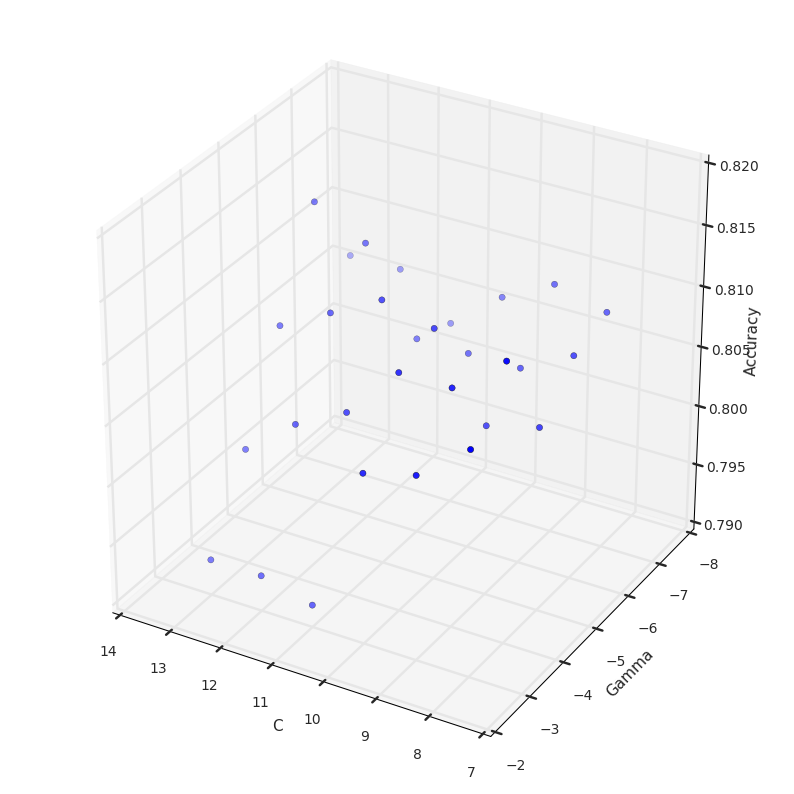

In [23]:
from mpl_toolkits.mplot3d import Axes3D

if useSVM and useCV:
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        C = [i.parameters['C'] for i in gscv.grid_scores_]
        gamma = [i.parameters['gamma'] for i in gscv.grid_scores_]
        accuracy = [i.mean_validation_score for i in gscv.grid_scores_] 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(np.log2(C), np.log2(gamma), accuracy)
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_zlabel('Accuracy')

    ax.view_init(30, 120)
    plt.show()

In [24]:
if useSVM:
    # Best CV accuracy: 0.814815, 
    # Best params: {'gamma': 0.015625, 'C': 8192.0, 'kernel': 'rbf'}
    print(best_params)
    svc.set_params(**best_params)
    svc.verbose=True
    
    print(X_train.shape)
    svc.fit(X_train, Y_train)

{'C': 8192.0, 'kernel': 'rbf', 'gamma': 0.015625}
(891, 31)
[LibSVM]

In [25]:
if useSVM:
    Y_pred = svc.predict(X_test)

    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })

    file_name = 'Test_predictions_svm_rbf_%g_%g.csv' % (svc.C, svc.gamma)
    submission.to_csv(file_name, index=False)

In [26]:
# Nearest Neighbours Classifieer

useNN = False

if useNN:
    print(X_train.shape)
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(X_train, Y_train)
    
    Y_pred = neigh.predict(X_test)
    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })

    file_name = 'Test_predictions_knn_%g.csv' % (neigh.n_neighbors)
    submission.to_csv(file_name, index=False)

In [27]:
print(check_output(["ls", "-alh", "."]).decode("utf8"))

total 396K
drwxr-xr-x 2 root root 4.0K Oct 30 21:15 .
drwxr-xr-x 5 root root 4.0K Oct 30 21:15 ..
-rw-r--r-- 1 root root 2.8K Oct 30 21:15 Test_predictions_svm_rbf_8192_0.015625.csv
-rw-r--r-- 1 root root  29K Oct 30 21:15 __notebook_source__.ipynb
-rw-r--r-- 1 root root 2.3K Oct 30 21:15 __output__.json
-rw-r--r-- 1 root root 342K Oct 30 21:15 __results__.html
-rw-r--r-- 1 root root    0 Oct 30 21:15 custom.css



In [28]:
# results
!cat *.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,0
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,1
921,0
922,0
923,0
924,0
925,0
926,0
927,0
928,0
929,0
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,1
939,0
940,1
941,0
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,0
961,0
962,1
963,0
964,0
965,1
966,1
967,0
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,1
977,0
978,1
979,0
980,1
981,0
982,0
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,0
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,0
1007,0
1008,0
1009,1
1010,0
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,0
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,1
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
10